In [ ]:
import h5py
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
from torch.nn.functional import interpolate

In [ ]:
from torchvision.transforms import transforms

In [ ]:
# CONFIG

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 8
NUM_WORKERS = 4
PATH = "/content/drive/MyDrive/gsoc/quark-gluon_data-set_n139306.hdf5"
epochs = 10
lr = 1e-3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class HDF5Dataset(Dataset):
    def __init__(self, file_path):
        self.file = h5py.File(file_path, 'r')
        self.data = self.file['X_jets']
        self.m0 = self.file['m0']
        self.pt = self.file['pt']
        self.y = self.file['y']

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        # Load X_jets in shape (125, 125, 3) from HDF5 file
        x_jets = self.data[idx]
        # Transpose the array to shape (3, 125, 125)
        x_jets = torch.tensor(x_jets.transpose(2, 0, 1)).detach().clone()
        return interpolate(x_jets.unsqueeze(0), size=(64,64), mode='bilinear', align_corners=False).squeeze(0)

In [32]:
dataset = HDF5Dataset(PATH)

indices = torch.arange(100)
train_dataset = Subset(dataset, indices)

In [ ]:
train_dataset.__getitem__(0).shape

torch.Size([3, 64, 64])

In [ ]:
from tqdm import tqdm

In [31]:
class Diffusion:
    def __init__(self, noise_steps=100, beta_start=1e-4, beta_end=0.02, img_size=256, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n):
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 1, self.img_size, self.img_size)).to(self.device)
            for i in reversed(range(1, self.noise_steps)):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

In [ ]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb



In [ ]:
class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 32)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 16)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 8)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 16)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 32)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

In [ ]:
import torchvision

In [29]:
def display_images(input_image, output_image, display=1):
    titles = ['Tracker', 'ECAL', 'HCAL']
    
    for d in range(display):
        # plot input images
        input_image_numpy = input_image.detach().cpu().numpy()
        plt.figure(figsize=(18,6))
        plt.suptitle('Original images // Reconstructed images', fontsize=20)

        # plot 4 images
        for i in range(len(titles)):
            plt.subplot(1, 3, i+1)
            
            plt.imshow(input_image_numpy[0][i], cmap='jet', vmin=0, vmax=0.01)
            plt.colorbar()
            plt.title(titles[i])
            plt.axis(False)

        plt.show()
                
        # plot output images
        output_image_numpy = output_image.detach().cpu().numpy()
        plt.figure(figsize=(18,6))

        # plot 4 images
        for i in range(len(titles)):
            plt.subplot(1, 3, i+1)
            
            plt.imshow(output_image_numpy[0][i], cmap='jet', vmin=0, vmax=0.01)
            plt.colorbar()
            plt.title(titles[i])
            plt.axis(False)
            
        plt.show()

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 100/100 [11:48<00:00,  7.09s/it]


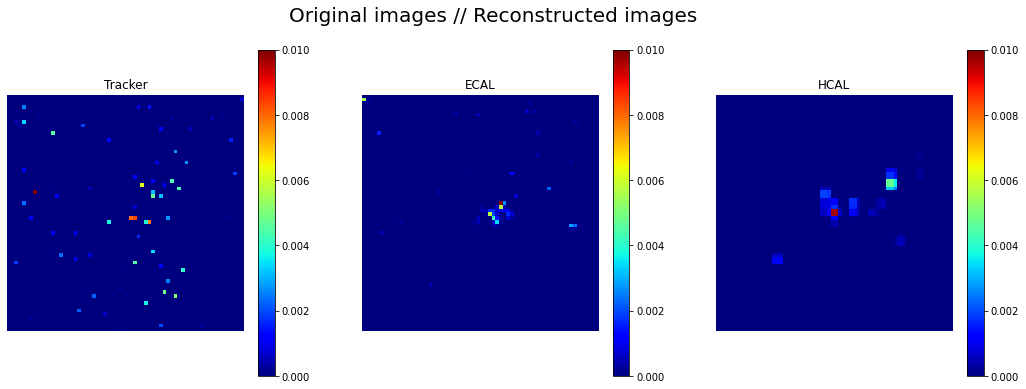

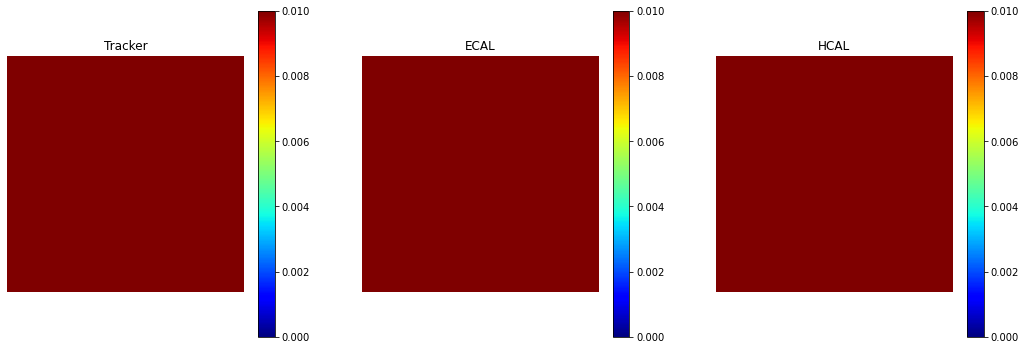

Loss:  17353.5234375


100%|██████████| 100/100 [11:39<00:00,  7.00s/it]


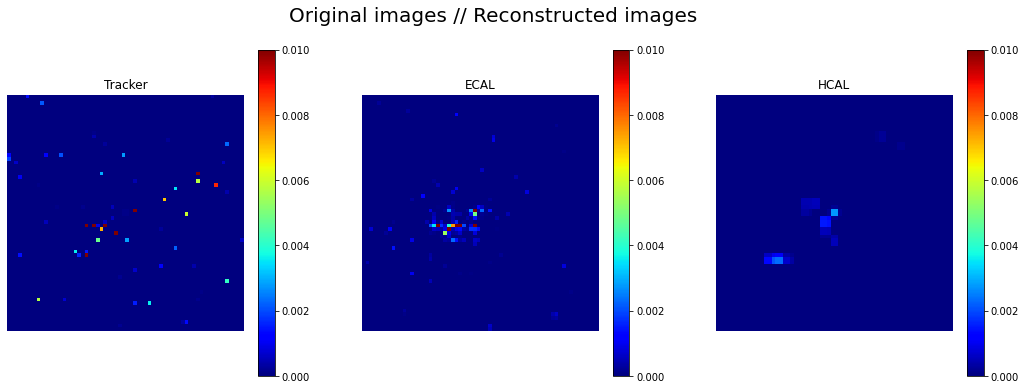

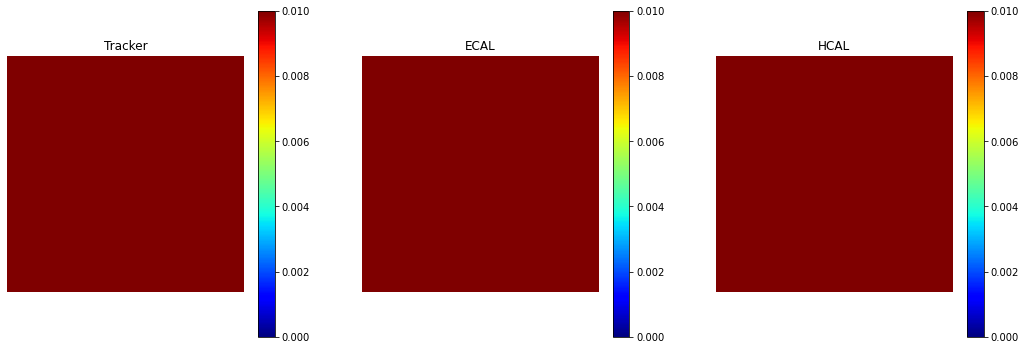

Loss:  17054.701171875


100%|██████████| 100/100 [11:41<00:00,  7.01s/it]


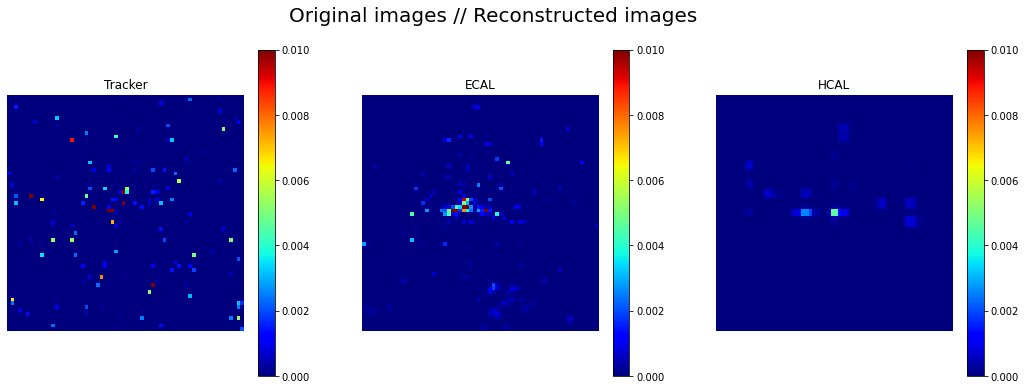

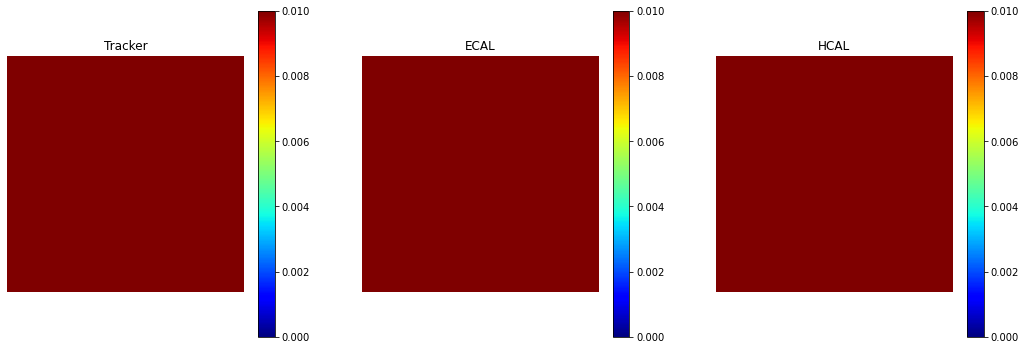

Loss:  19161.09765625


  3%|▎         | 3/100 [00:30<14:42,  9.10s/it]

In [ ]:
device = DEVICE
dataloader = DataLoader(train_dataset, shuffle=True, num_workers=NUM_WORKERS)
model = UNet(c_in=1, c_out=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)
mse = nn.MSELoss()
diffusion = Diffusion(img_size=64, device=device)
l = len(dataloader)

for epoch in range(epochs):
    for i, images in enumerate(tqdm(dataloader)):
        images = images.to(device)
        outputs_list = []

        for channel in range(3):
          data_channel = images[:, channel].unsqueeze(1)
          t = diffusion.sample_timesteps(data_channel.shape[0]).to(device)
          x_t, noise = diffusion.noise_images(data_channel, t)
          predicted_noise = model(x_t, t)
          loss = mse(noise, predicted_noise)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          outputs_list.append(diffusion.sample(model, n=data_channel.shape[0]))

    outputs_list = torch.cat(outputs_list, dim=1) # concatenate Tracker, ECAL, HCAL images
    display_images(images, outputs_list)
    print("Loss: ",mse(images,outputs_list).item())